In [1]:
import time

import matplotlib.pyplot as plt
from pytorch_lightning.metrics.functional import accuracy, precision_recall, f1
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

from model import GarbageModel
from util import make_ensemble, time_to_string

c:\Users\LUKE_SARGEN\anaconda3\envs\pytorch110cu113\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\LUKE_SARGEN\anaconda3\envs\pytorch110cu113\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\LUKE_SARGEN\anaconda3\envs\pytorch110cu113\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
model_paths = [
        # "logs/subset/version_87/last.ckpt",  # mobilenet_v3_small.attn
        "logs/subset/version_91/last.ckpt",  # resnet50.attn
]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device : {}".format(device))
model = make_ensemble(model_paths, GarbageModel, device)

Device : cuda:0
 * Loading ensemble ...
Adding logs/subset/version_91/last.ckpt
Categories : ['mmmm', 'nah', 'nnnn', 'oooo', 'qqqq']
Input Size : 256
 * Ensemble loaded.


In [28]:
# root = "data/test448"
root = r"C:\Users\LUKE_SARGEN\projects\datasets\test512"
batch_size = 224
use_crops = False
input_size = 224  # model.input_size, 128, 192, 224, 256, 288, 320, 384, 448, 512

if use_crops:
    valid_transform = T.Compose([
        T.Resize(int(1.05*input_size)),
        T.FiveCrop(input_size),
        # T.TenCrop(input_size),
        T.Lambda(lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops])),
    ])
else:
    valid_transform = T.Compose([
        T.Resize(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(input_size),
        T.ToTensor(),
    ])
valid_ds = ImageFolder(root=root, transform=valid_transform)
num_classes = len(valid_ds.classes)
val_loader = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)
print("{} Test Samples.".format(len(valid_ds)))

3000 Test Samples.


In [29]:
torch.cuda.empty_cache()
yhats = []  # All model predictions
ensemble = []  # Mean prediction
targets = []  # Targets
t0 = time.time()
i = 0
for (data, target) in val_loader:
    data = data.to(device)
    if use_crops:
        bs, ncrops, c, h, w = data.size()
        data = data.view(-1, c, h, w)
        with torch.no_grad():
            ymodels = [torch.softmax(m(data.clone()), dim=1).view(bs, ncrops, -1).mean(1) for m in model.models]
        avg_pred = torch.mean(torch.stack(ymodels), dim=0)
        yhat = torch.stack([torch.argmax(y, dim=1) for y in ymodels])
    else:
        with torch.no_grad():
            ymodels = [torch.softmax(m(data.clone()), dim=1) for m in model.models]
        avg_pred = torch.mean(torch.stack(ymodels), dim=0)
        yhat = torch.stack([torch.argmax(y, dim=1) for y in ymodels])
    yhats.append(yhat)
    ensemble.append(avg_pred)
    targets.append(target)
    if i%max(1, int(len(valid_ds)/(batch_size*10)))==0:
        c = len(targets)*batch_size
        duration = time.time()-t0
        remaining = duration/c * (len(valid_ds)-c)
        print("image {}/{}. {:.1f} images/second. elapsed={}. remaining={}.".format(c, len(valid_ds), c/duration, time_to_string(duration), time_to_string(remaining)))
    i += 1

preds = torch.cat(yhats, dim=1).cpu()
pred = torch.argmax(torch.cat(ensemble), dim=1).cpu()
target = torch.cat(targets).cpu()
c = len(target)
duration = time.time()-t0
remaining = duration/c * (len(valid_ds)-c)
print("image {}/{}. {:.1f} images/second. elapsed={}.".format(c, len(valid_ds), c/duration, time_to_string(duration)))
print("preds.shape :", preds.shape)
print("pred.shape :", pred.shape)
print("target.shape :", target.shape)

image 224/3000. 138.8 images/second. elapsed=1.61 seconds. remaining=20.00 seconds.
image 448/3000. 138.7 images/second. elapsed=3.23 seconds. remaining=18.39 seconds.
image 672/3000. 142.8 images/second. elapsed=4.71 seconds. remaining=16.31 seconds.
image 896/3000. 145.7 images/second. elapsed=6.15 seconds. remaining=14.44 seconds.
image 1120/3000. 146.6 images/second. elapsed=7.64 seconds. remaining=12.82 seconds.
image 1344/3000. 147.2 images/second. elapsed=9.13 seconds. remaining=11.25 seconds.
image 1568/3000. 146.9 images/second. elapsed=10.68 seconds. remaining=9.75 seconds.
image 1792/3000. 146.8 images/second. elapsed=12.21 seconds. remaining=8.23 seconds.
image 2016/3000. 146.6 images/second. elapsed=13.76 seconds. remaining=6.71 seconds.
image 2240/3000. 146.2 images/second. elapsed=15.33 seconds. remaining=5.20 seconds.
image 2464/3000. 146.0 images/second. elapsed=16.87 seconds. remaining=3.67 seconds.
image 2688/3000. 145.9 images/second. elapsed=18.42 seconds. remainin

In [30]:
def stats(pred, target):
    acc = accuracy(pred, target)
    avg_precision, avg_recall = precision_recall(pred, target, num_classes=num_classes, average="macro", mdmc_average="global")
    weighted_f1 = f1(pred, target, num_classes=num_classes, threshold=0.5, average="weighted")
    return 100*acc, 100*avg_precision, 100*avg_recall, 100*weighted_f1

archs = [m.hparams.model for m in model.models]
headers = ["Model", "Arch", "Accuracy", "Precision", "Recall", "F1 Score"]
hw = max(len(n) for n in headers)
aw = max(len(n) for n in archs)
width = max(len(n) for n in headers)
head_fmt = '{:>{hw}s}' + ' {:>{aw}s}' + ' {:>{hw}s}'*(len(headers)-2) + '\n'
row_fmt = '{:>{hw}s}' + ' {:>{aw}s}' + ' {:>9.2f}'*(len(headers)-2) + '\n'
stat_str = head_fmt.format(*headers, hw=hw, aw=aw)
for i in range(len(model.models)):
    row = stats(preds[i, :], target)
    stat_str += row_fmt.format(str(i), str(archs[i]),*row, hw=hw, aw=aw)
row = stats(pred, target)
stat_str += row_fmt.format("Ensemble", "", *row, hw=hw, aw=aw)
print(stat_str)

    Model          Arch  Accuracy Precision    Recall  F1 Score
        0 resnet50.attn     59.93     60.46     59.42     59.69
 Ensemble                   59.93     60.46     59.42     59.69



In [31]:
print( classification_report(target, pred, target_names=model.classes, digits=4) )

              precision    recall  f1-score   support

        mmmm     0.4427    0.3710    0.4037       531
         nah     0.7888    0.4913    0.6055       631
        nnnn     0.7257    0.6908    0.7078       747
        oooo     0.5551    0.7293    0.6304       580
        qqqq     0.5109    0.6888    0.5867       511

    accuracy                         0.5993      3000
   macro avg     0.6046    0.5942    0.5868      3000
weighted avg     0.6193    0.5993    0.5969      3000



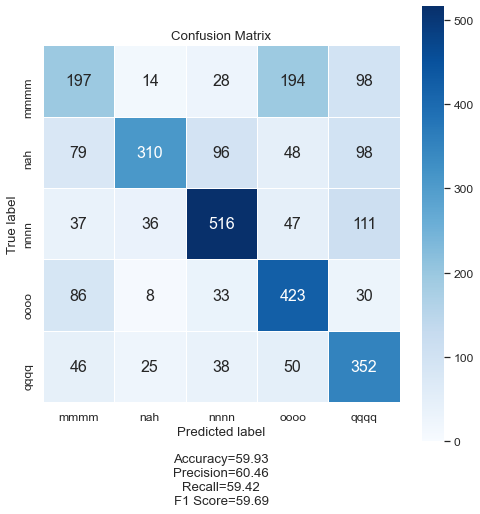

In [32]:
cm = confusion_matrix(target, pred)
plt.figure(figsize=(8, 8))
sn.set(font_scale=1.1)  # Label size
sn.heatmap(cm, annot=True, fmt="d",
cmap='Blues',
# cbar=False,
vmin=0,
xticklabels=model.classes,  yticklabels=model.classes, annot_kws={"size": 16}, square=True, linewidths=0.5)
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label\n\nAccuracy={:.2f}\nPrecision={:.2f}\nRecall={:.2f}\nF1 Score={:.2f}'.format(*row))
plt.savefig('data/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()